In [59]:
import glob
import os, sys
os.path.abspath(os.getcwd())
sys.path.append("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\cit_for_computation")

import torch
import torch.nn as nn
import pandas
import numpy as np
import numpy.ma as ma
import pickle
import time
import seaborn as sns
import scipy.stats as st

import proplot as pplt
import sklearn
import re 
from fractions import Fraction

from utils import *
from plotting_functions import *

In [60]:
label_size = 12
pplt.rc['tick.labelsize'] = label_size 
pplt.rc['axes.labelsize'] = label_size + 3

In [90]:
#load model
current_dir = "C:\\Users\\abel_\\Documents\\Rotations\\CIT\\cit_for_computation"
# exp_extension = "\\experiments\\poisson_clicks\\\cued_curr_no25\\"
# exp_extension = "\\experiments\\poisson_clicks\\\cued_curr_4\\"
exp_extension = "\\experiments\\poisson_clicks\\"

# 8288: N30
# 3892: N100
# 9363: 
exp_list = glob.glob(current_dir + exp_extension + "\\exp*actnorm*04") 
exp_list = glob.glob(current_dir + exp_extension + "\\exp*63") 
# exp_list = sorted(exp_list, key = lambda x: int(x.split("Nrec")[-1].split("_")[-1]))
exp_path = exp_list[0]
exp_path
exp_list

['C:\\Users\\abel_\\Documents\\Rotations\\CIT\\cit_for_computation\\experiments\\poisson_clicks\\exp_targetwithcue_learningrate0.0001_bcewll_adam_cosineannealing_rnn_cued_loadmodel_Nrec3_1667499363']

In [94]:
with open(exp_path + '\\training_kwargs.pickle', 'rb') as handle:
    training_kwargs = pickle.load(handle)

training_kwargs['exp_path'] = exp_path
training_kwargs['training_weights_path'] = exp_path + '/training/'
training_kwargs['figures_path'] = exp_path + '//figures/'

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu' #training_kwargs['device']
training_kwargs['device'] = device
rnn_model = RNNModel(training_kwargs['N_in'], training_kwargs['N_out'], training_kwargs['N_rec'], n_layers=1, transform_function='relu').to(device)
rnn_model = load_model(rnn_model, training_kwargs)

C:\Users\abel_\Documents\Rotations\CIT\cit_for_computation\experiments\poisson_clicks\exp_targetwithcue_learningrate0.0001_bcewll_adam_cosineannealing_rnn_cued_loadmodel_Nrec3_1667499363\weights1667499363.pth


In [95]:
# with open(exp_path + "\\curriculum_dataset.pickle", 'rb') as handle:
#     curriculum_dataset = pickle.load(handle)
    
# for coherence in curriculum_dataset.keys():
#     train_set, test_set = curriculum_dataset[coherence]
#     test_x, y, output_mask, trial_params = train_set
#     inputs = torch.tensor(test_x, dtype=torch.float)
#     yhat, hidden = rnn_model(inputs)
#     yhat_np = yhat.cpu().detach().numpy()

#     accuracy, response_correctness, choice_proportion_per_ratio, average_accuracy_per_ratio, N_clicks, highest_click_count_index, chosen = get_accuracy_poissonclicks(test_x, yhat_np, output_mask, trial_params)

#     print("Coherence:", coherence, ",   Accuracy:", accuracy)

In [96]:
with open(exp_path + "\\dataset.pickle", 'rb') as handle:
    dataset = pickle.load(handle)
train_set, test_set = dataset
x, y, output_mask, trial_params = train_set

In [97]:
N_test_batch = 10**5
# make dataset with all cohs if curriculum learning
# test_kwargs = training_kwargs.copy()
# test_kwargs['ratios'].append(float(1.))
# test_kwargs['ratios'] = sorted(test_kwargs['ratios'])
training_kwargs['equal_clicks'] = ''
pd = PoissonClicks(N_batch=N_test_batch, training_kwargs=training_kwargs)
x, y, output_mask, trial_params = pd.get_trial_batch() 

yhat, hidden_states = run_model_chunked(x, rnn_model, hidden_initial_variance=training_kwargs['hidden_initial_variance'], n_chunks=100)

In [98]:
yhat = yhat.cpu().detach().numpy()
accuracy, response_correctness, N_clicks, highest_click_count_index, chosen, excludeequals = get_accuracy_poissonclicks_w(x, yhat, output_mask)

print("Accuracy:", accuracy)

Accuracy: 1.0


In [99]:
# chosen_without_equals = 1-np.argmax(np.mean(yhat*output_mask, axis=1), axis = 1)[excludeequals]
# df = pandas.DataFrame({"Choice": chosen_without_equals, "Difference": N_clicks[excludeequals,0]-N_clicks[excludeequals,1]})
# average_perclick = df.groupby("Difference").mean()

# pplt.figure(figsize=(6,4))
# ax = plt.subplot(111)
# ax.plot(np.sort(df['Difference'].unique()), average_perclick['Choice'].to_numpy(), 'x-')

# ax.set_xlabel("Difference in clicks")
# ax.set_ylabel("Proportion of right choices")

# plt.savefig(training_kwargs['figures_path'] + "\\psycho_curve.pdf")
# plt.savefig(training_kwargs['figures_path'] + "\\psycho_curve.png")

C:\Users\abel_\anaconda3\envs\CIT_\lib\site-packages\scipy\stats\_distn_infrastructure.py:2343: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\Users\abel_\anaconda3\envs\CIT_\lib\site-packages\scipy\stats\_distn_infrastructure.py:2344: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


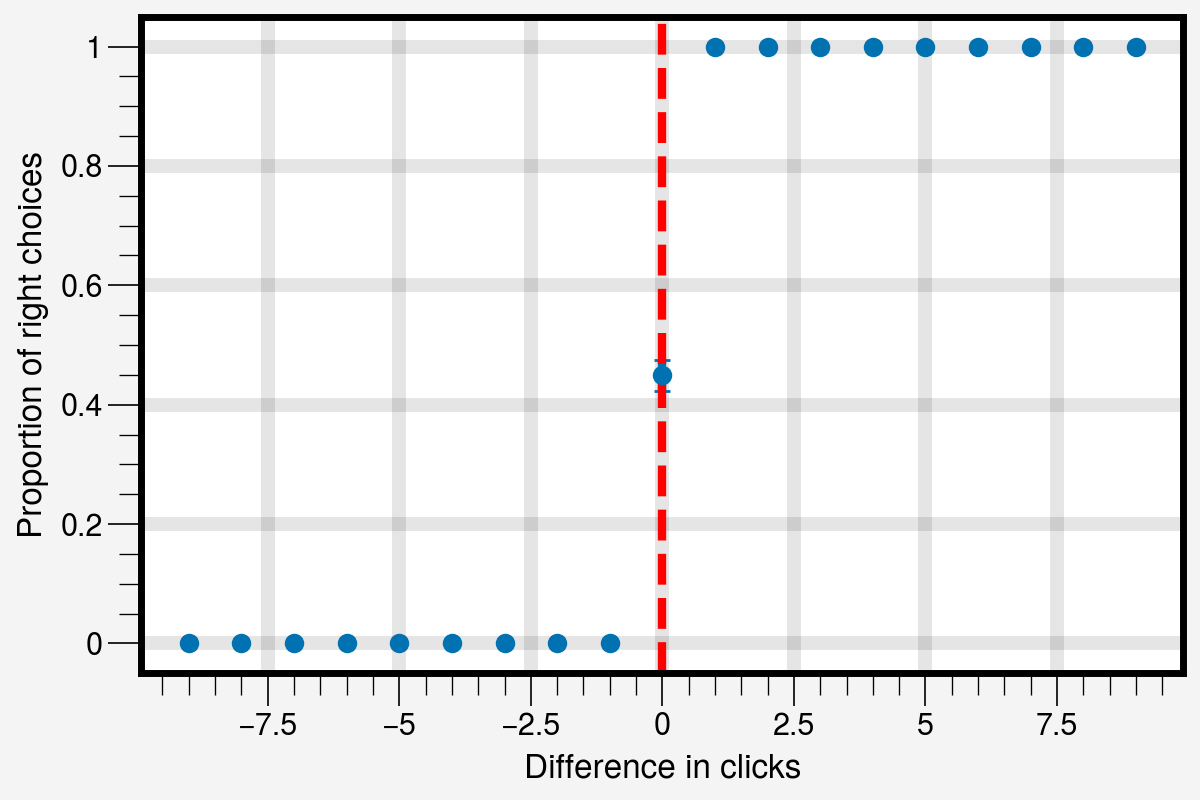

In [100]:
sns.set_context("poster", font_scale = .5, rc={"grid.linewidth": 5})
pplt.figure(figsize=(6,4))
ax = plt.subplot(111)
chosen = 1-np.argmax(np.mean(yhat*output_mask, axis=1), axis = 1)
df = pandas.DataFrame({"Choice": chosen, "Difference": N_clicks[:,0]-N_clicks[:,1]})
df = df[abs(df['Difference']) < 10]
ci = np.array([st.t.interval(0.95, len(df['Choice'][df["Difference"] == i])-1, loc=np.mean(df['Choice'][df["Difference"] == i]), scale=st.sem(df['Choice'][df["Difference"] == i])) for i in np.sort(df['Difference'].unique())])
average_perclick = df.groupby("Difference").mean()
std_perclick = df.groupby("Difference").std().to_numpy().squeeze()
ax.errorbar(np.sort(df['Difference'].unique()), average_perclick['Choice'].to_numpy(), yerr=np.abs(ci.T-average_perclick.to_numpy().T),
            fmt='.')
ax.axvline(x = 0, color = 'r', linestyle = '--')

ax.set_xlabel("Difference in clicks")
ax.set_ylabel("Proportion of right choices")
plt.savefig(training_kwargs['figures_path'] + "/psycho_curve.pdf")
plt.savefig(training_kwargs['figures_path'] + "/psycho_curve.png")

In [101]:
#get mistakes
accuracy, response_correctness, choice_proportion_per_ratio, average_accuracy_per_ratio, N_clicks, highest_click_count_index, chosen = get_accuracy_poissonclicks(x, yhat, output_mask, trial_params)

error_idx = np.where(response_correctness==False)[0]
accuracy

1.0

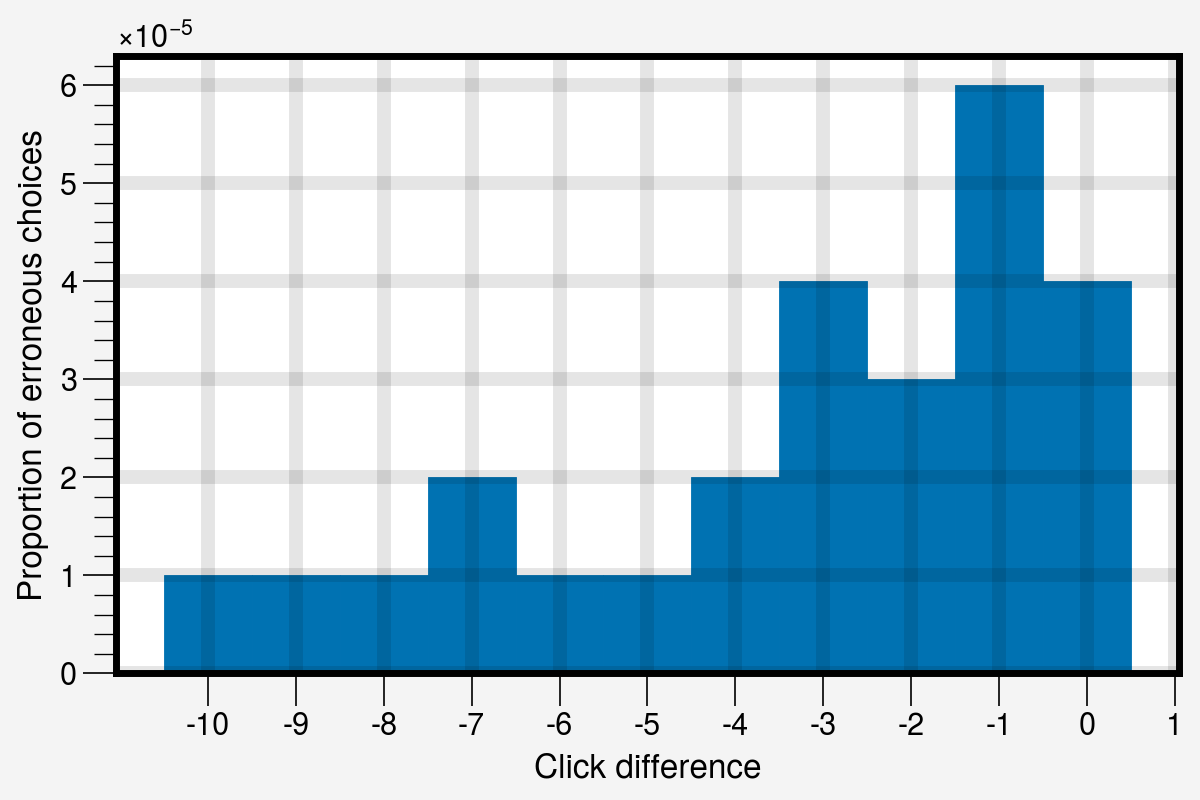

In [87]:
accuracy, response_correctness, N_clicks, highest_click_count_index, chosen, excludeequals = get_accuracy_poissonclicks_w(x, yhat, output_mask)

pplt.figure(figsize=(6,4))
ax = plt.subplot(111)
click_diffs = N_clicks[error_idx][:,0]-N_clicks[error_idx][:,1]
bins = np.arange(int(np.min(click_diffs)),int(np.max(click_diffs)))

plt.hist(click_diffs, bins=bins,  weights=np.ones(len(click_diffs)) / N_test_batch)
ax.set_xlabel("Click difference")
ax.set_ylabel("Proportion of erroneous choices")
ax.set_xticks(bins+.5)
ax.set_xticklabels(bins)
ax.tick_params(axis='x', which='minor', bottom=False)
plt.savefig(training_kwargs['figures_path'] + "\\errors_per_clickdifference.pdf")
plt.savefig(training_kwargs['figures_path'] + "\\errors_per_clickdifference.png")

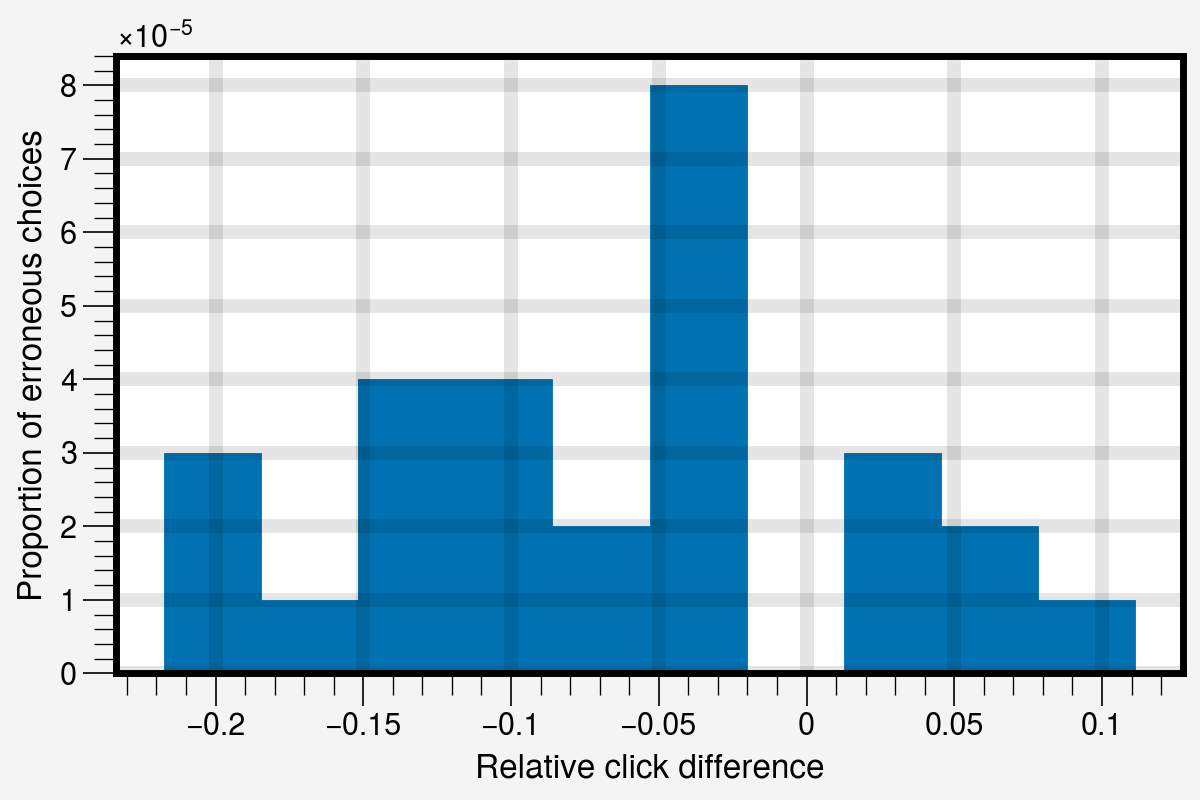

In [88]:
pplt.figure(figsize=(6,4))
ax = plt.subplot(111)
click_diffs = N_clicks[error_idx][:,0]-N_clicks[error_idx][:,1]
click_reldiffs = (N_clicks[error_idx][:,0]-N_clicks[error_idx][:,1])/(N_clicks[error_idx][:,0]+N_clicks[error_idx][:,1])
plt.hist(click_reldiffs, bins=10,  weights=np.ones(len(click_reldiffs)) / N_test_batch)
ax.set_xlabel("Relative click difference")
ax.set_ylabel("Proportion of erroneous choices")

plt.savefig(training_kwargs['figures_path'] + "\\errors_per_relativeclickdifference.pdf")
plt.savefig(training_kwargs['figures_path'] + "\\errors_per_relativeclickdifference.png")

In [16]:
chosen = np.argmax(np.mean(yhat*output_mask, axis=1), axis = 1)
truth = np.argmax(np.mean(y*output_mask, axis = 1), axis = 1)
response_correctness = np.equal(truth, chosen)
error_idx = np.where(response_correctness==False)[0]

Click difference: 1.0


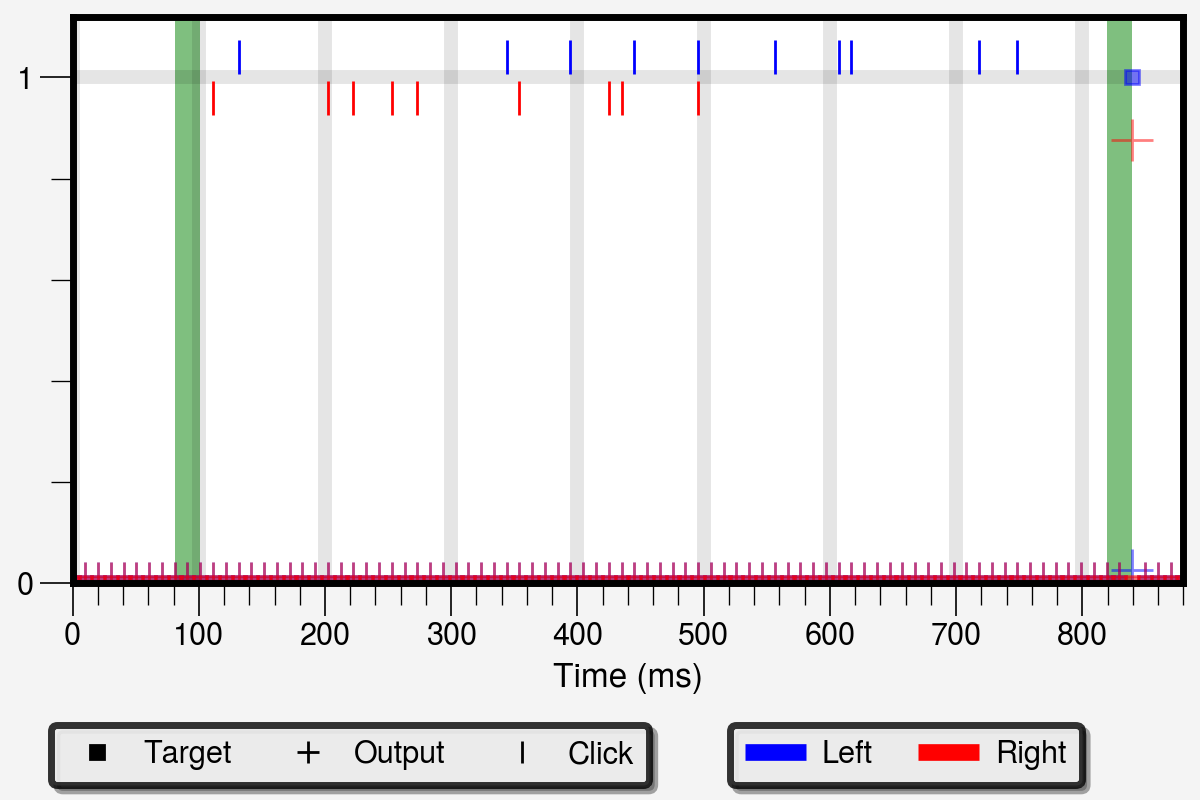

In [17]:
accuracy, response_correctness, choice_proportion_per_ratio, average_accuracy_per_ratio, N_clicks, highest_click_count_index, chosen = get_accuracy_poissonclicks(x, yhat, output_mask, trial_params)
wrong_trials = get_wrong_trials(N_clicks, chosen)
trial_i = wrong_trials[0]
print("Click difference:", N_clicks[trial_i,0]-N_clicks[trial_i,1])
plot_trial(trial_i, x=x, y=y, yhat=yhat,
           training_kwargs=training_kwargs,
           file_name="wrong_trial_example",
           eps = 0.04, padding = 5,
          maxT="part",
          trial_params=trial_params);

Click difference: 1.0


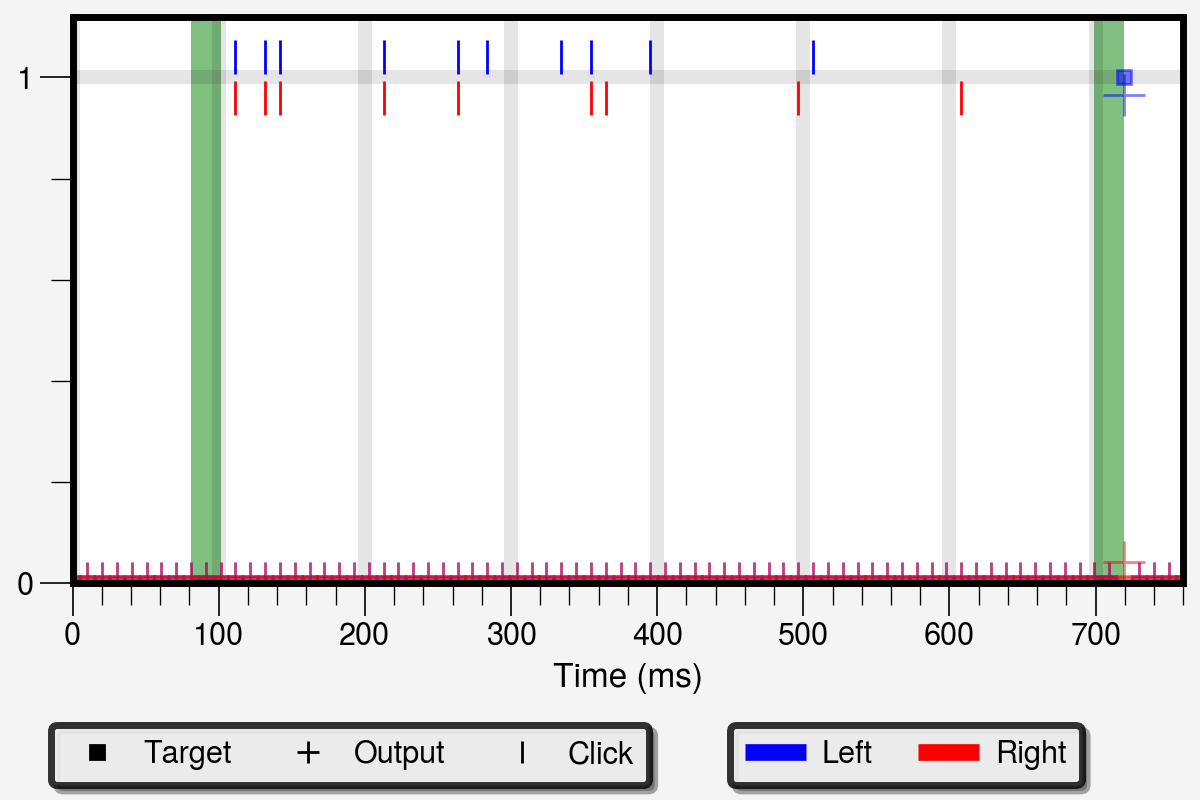

In [19]:
correct_idx = np.where(response_correctness==True)[0]
correct_trial_i = 11
trial_i = correct_idx[correct_trial_i]

print("Click difference:", N_clicks[trial_i,0]-N_clicks[trial_i,1])
plot_trial(trial_i, x=x, y=y, yhat=yhat,
           training_kwargs=training_kwargs,
           file_name="example_correct_trial",
           eps = 0.04, padding = 5,
          maxT="part",
          trial_params=trial_params);

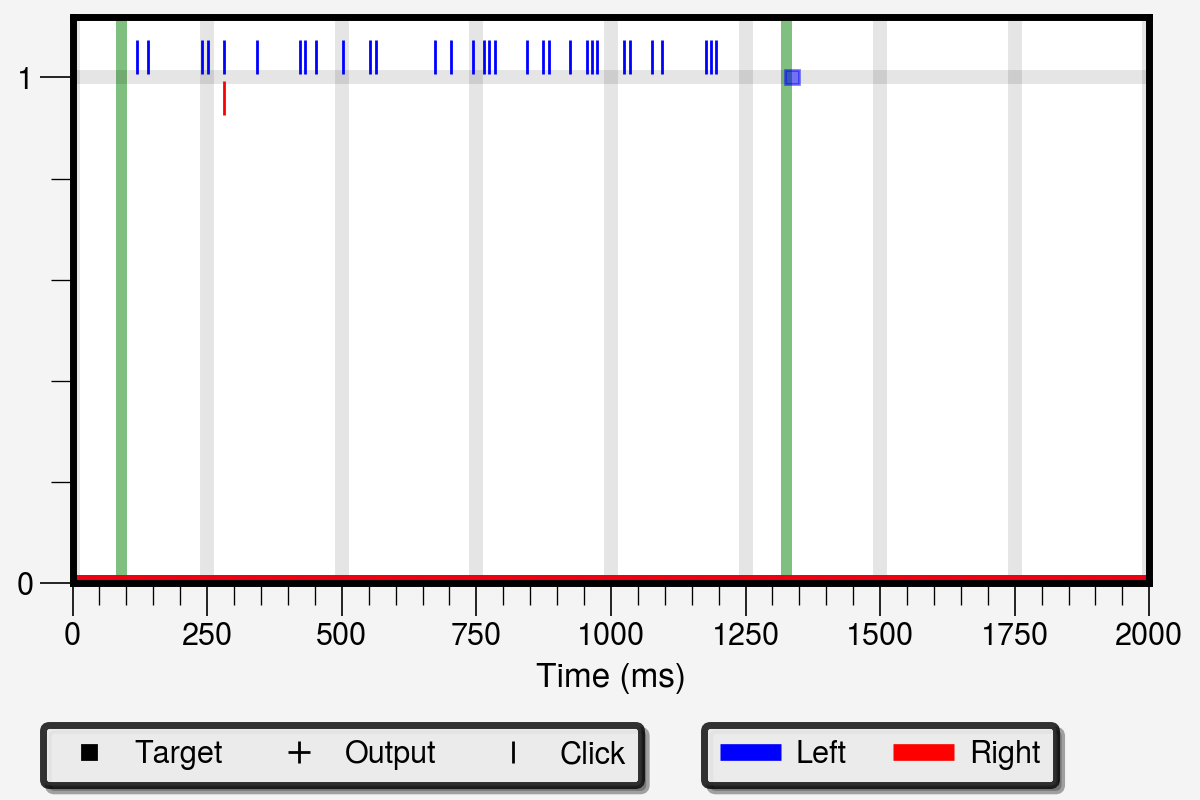

In [23]:
trial_i = 66

plot_trial(trial_i, x=x, y=y, yhat=np.nan*yhat,
           training_kwargs=training_kwargs,
           file_name="example_trial_setup",
           eps = 0.04, padding = 5,
          maxT="full",
          trial_params=trial_params);

In [56]:
#ROC
accuracy, response_correctness, N_clicks, highest_click_count_index, chosen, excludeequals = get_accuracy_poissonclicks_w(x, yhat, output_mask)

from sklearn.metrics import roc_curve, auc

In [57]:
from scipy.special import softmax
np.set_printoptions(precision=5)

data = yhat*output_mask
data[data == 0] = np.nan
output_mean = np.nanmean(data, axis=1)

C:\Users\abel_\AppData\Local\Temp\ipykernel_12888\4099802455.py:6: RuntimeWarning: Mean of empty slice
  output_mean = np.nanmean(data, axis=1)


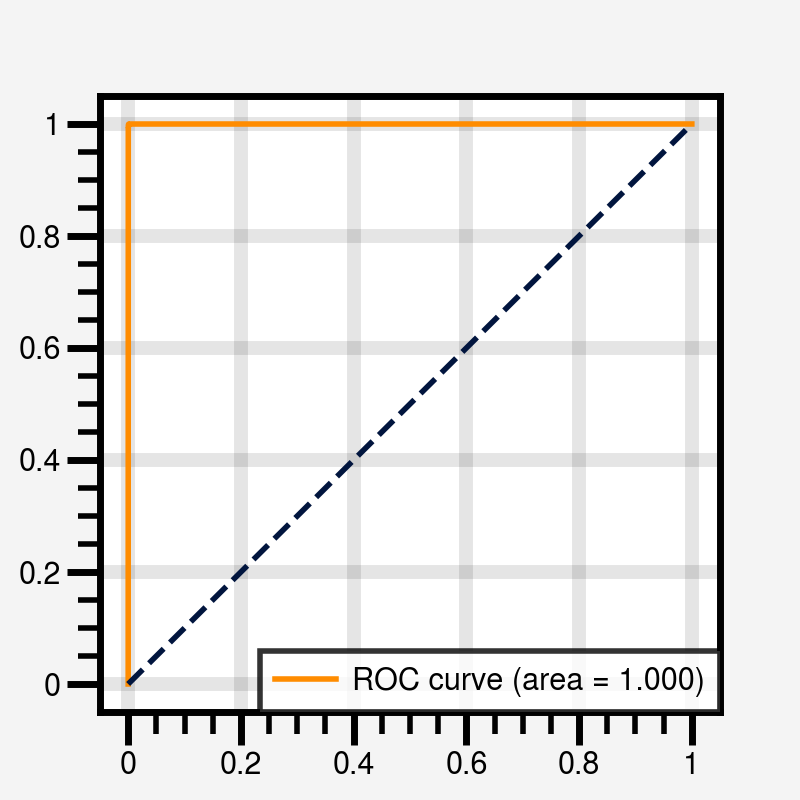

In [58]:
#ROC
accuracy, response_correctness, N_clicks, highest_click_count_index, chosen, excludeequals = get_accuracy_poissonclicks_w(x, yhat, output_mask)

truth = highest_click_count_index[excludeequals]
fpr, tpr, thresholds = roc_curve(truth, output_mean[...,1][excludeequals])
roc_auc = auc(fpr, tpr)

lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.3f)" % roc_auc,
)
plt.legend()
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--");
plt.savefig(training_kwargs['figures_path'] + "\\roc.pdf")
plt.savefig(training_kwargs['figures_path'] + "\\roc.png")